# ICU Occupancy Forecast with Prophet (COVID-19, Italy)

## Set - up

In [323]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

## Parameters

In [324]:
URL_DATA   = ("https://raw.githubusercontent.com/pcm-dpc/COVID-19/"
              "master/dati-regioni/dpc-covid19-ita-regioni.csv")

USE_REGION = True                       # False ➜ aggregate Italy
REGIONE    = "Lombardia"                # used only if USE_REGION = True
POSTI_TI   = 1200                       # ICU bed capacity for the region
HORIZON    = 120                         # forecast horizon (days)

LAG_POS    = 10                         # days between positives ➜ ICU stock
LAG_ING    = 7                          # days between ICU admissions ➜ stock
ROLL_WIN   = 3                          # rolling median window for smoothing

## Data

In [325]:
df = pd.read_csv(URL_DATA, parse_dates=["data"]).sort_values("data")

if USE_REGION:
    df = df.query("denominazione_regione == @REGIONE").copy()
else:                                   # aggregate over Italy
    df = (df.groupby("data", as_index=False)
            .agg({"terapia_intensiva": "sum",
                  "nuovi_positivi": "sum",
                  "ingressi_terapia_intensiva": "sum"}))
    REGIONE = "Italia"
    POSTI_TI = int(df["terapia_intensiva"].max() * 1.3)  # rough cap

In [326]:
df.sort_values("data", ascending=False).head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2
37388,2025-01-08 17:00:00,ITA,3,Lombardia,45.466794,9.190347,110,3,113,843,...,NaN,0.0,NaN,NaN,1558738.0,2833206.0,17263179.0,30533999.0,ITC,ITC4
37367,2025-01-07 17:00:00,ITA,3,Lombardia,45.466794,9.190347,98,4,102,886,...,NaN,0.0,NaN,NaN,1558697.0,2833140.0,17262860.0,30532057.0,ITC,ITC4
37346,2025-01-06 17:00:00,ITA,3,Lombardia,45.466794,9.190347,100,4,104,862,...,NaN,0.0,NaN,NaN,1558689.0,2833109.0,17262658.0,30531189.0,ITC,ITC4
37325,2025-01-05 17:00:00,ITA,3,Lombardia,45.466794,9.190347,98,4,102,858,...,NaN,0.0,NaN,NaN,1558685.0,2833081.0,17262516.0,30530541.0,ITC,ITC4
37304,2025-01-04 17:00:00,ITA,3,Lombardia,45.466794,9.190347,96,5,101,828,...,NaN,1.0,NaN,NaN,1558675.0,2833045.0,17262330.0,30529618.0,ITC,ITC4


## Pre-processing

In [327]:
df = df.rename(columns={"data": "ds"})
df["y"] = (df["terapia_intensiva"]
             .rolling(ROLL_WIN, center=True)
             .median()
             .bfill())

In [328]:
df.head()

,ds,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2,y
8,2020-02-24 18:00:00,ITA,3,Lombardia,45.466794,9.190347,76,19,95,71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0
29,2020-02-25 18:00:00,ITA,3,Lombardia,45.466794,9.190347,79,25,104,127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0
50,2020-02-26 18:00:00,ITA,3,Lombardia,45.466794,9.190347,79,25,104,145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0
71,2020-02-27 18:00:00,ITA,3,Lombardia,45.466794,9.190347,172,41,213,136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0
92,2020-02-28 18:00:00,ITA,3,Lombardia,45.466794,9.190347,235,47,282,192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0


In [329]:


# Lagged regressors
df[f"nuovi_pos_lag{LAG_POS}"]    = df["nuovi_positivi"].shift(LAG_POS)
df[f"ingressi_ti_lag{LAG_ING}"]  = df["ingressi_terapia_intensiva"].shift(LAG_ING)
df[f"ricoverati_con_sintomi_lag{LAG_ING}"]  = df["ricoverati_con_sintomi"].shift(LAG_ING)

In [330]:
df["cap"]   = POSTI_TI           # upper bound for logistic growth
df["floor"] = 0
df = df[["ds", "y", f"nuovi_pos_lag{LAG_POS}", f"ingressi_ti_lag{LAG_ING}", f"ricoverati_con_sintomi_lag{LAG_ING}", "cap", "floor", "nuovi_positivi", "ingressi_terapia_intensiva", "ricoverati_con_sintomi"]]
df = df.dropna().reset_index(drop=True)

In [331]:
df.sort_values("ds", ascending=False).head()

,ds,y,nuovi_pos_lag10,ingressi_ti_lag7,ricoverati_con_sintomi_lag7,cap,floor,nuovi_positivi,ingressi_terapia_intensiva,ricoverati_con_sintomi
1489,2025-01-07 17:00:00,4.0,92.0,1.0,86.0,1200,0,39,0.0,98
1488,2025-01-06 17:00:00,4.0,31.0,0.0,75.0,1200,0,32,0.0,100
1487,2025-01-05 17:00:00,4.0,13.0,0.0,74.0,1200,0,46,0.0,98
1486,2025-01-04 17:00:00,5.0,55.0,0.0,52.0,1200,0,72,1.0,96
1485,2025-01-03 17:00:00,5.0,88.0,1.0,78.0,1200,0,88,1.0,86


## Model training

In [332]:
train, test = df.iloc[:-HORIZON], df.iloc[-HORIZON:]

m = Prophet(
        growth="logistic",
        weekly_seasonality=True,
        daily_seasonality=False,
        yearly_seasonality=False,
        seasonality_mode="additive",
        changepoint_prior_scale=0.05)

m.add_regressor(f"nuovi_pos_lag{LAG_POS}", prior_scale=5)
m.add_regressor(f"ingressi_ti_lag{LAG_ING}", prior_scale=5)
m.add_regressor(f"ricoverati_con_sintomi_lag{LAG_ING}", prior_scale=5)

m.fit(train)

08:32:51 - cmdstanpy - INFO - Chain [1] start processing
08:32:51 - cmdstanpy - INFO - Chain [1] done processing


## Prediction

In [333]:
future = m.make_future_dataframe(periods=5000)

#  Re-merge to compute lag features on the extended range
full = (pd.concat([df, future], ignore_index=True)
          .sort_values("ds")
          .reset_index(drop=True))

full[f"nuovi_pos_lag{LAG_POS}"]   = full["nuovi_positivi"].shift(LAG_POS)
full[f"ingressi_ti_lag{LAG_ING}"] = full["ingressi_terapia_intensiva"].shift(LAG_ING)
full[f"ricoverati_con_sintomi_lag{LAG_ING}"] = full["ricoverati_con_sintomi"].shift(LAG_ING)
full["cap"]   = POSTI_TI
full["floor"] = 0
future = full.loc[future.index]    # keep only rows Prophet needs
future = future.dropna().reset_index(drop=True)

forecast = m.predict(future)

In [334]:
forecast.sort_values("ds", ascending=False).head()

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,...,ricoverati_con_sintomi_lag7,ricoverati_con_sintomi_lag7_lower,ricoverati_con_sintomi_lag7_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
330,2025-01-05 17:00:00,105.911355,1200,0,-26.851542,58.815003,104.503339,107.226989,-90.411209,-90.411209,...,-86.602526,-86.602526,-86.602526,7.671921,7.671921,7.671921,0.0,0.0,0.0,15.500146
329,2025-01-01 17:00:00,105.705056,1200,0,-36.467795,42.863413,104.365706,106.952770,-101.129003,-101.129003,...,-86.862932,-86.862932,-86.862932,-3.007136,-3.007136,-3.007136,0.0,0.0,0.0,4.576053
328,2024-12-31 17:00:00,105.653538,1200,0,-32.666691,46.264927,104.343224,106.881013,-99.723657,-99.723657,...,-86.515723,-86.515723,-86.515723,-5.409060,-5.409060,-5.409060,0.0,0.0,0.0,5.929880
327,2024-12-26 17:00:00,105.396288,1200,0,-41.742868,42.826938,104.197887,106.518425,-107.015600,-107.015600,...,-86.428921,-86.428921,-86.428921,-9.209352,-9.209352,-9.209352,0.0,0.0,0.0,-1.619311
326,2024-12-22 17:00:00,105.190896,1200,0,-21.812195,60.602668,104.045499,106.259977,-86.085645,-86.085645,...,-85.734503,-85.734503,-85.734503,7.671921,7.671921,7.671921,0.0,0.0,0.0,19.105251


## Evaluation

In [335]:
pred_df = forecast.merge(df[["ds", "y"]], on="ds", how="inner")

In [336]:
pred_df.columns

Index(['ds', 'trend', 'cap', 'floor', 'yhat_lower', 'yhat_upper',
       'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'extra_regressors_additive',
       'extra_regressors_additive_lower', 'extra_regressors_additive_upper',
       'ingressi_ti_lag7', 'ingressi_ti_lag7_lower', 'ingressi_ti_lag7_upper',
       'nuovi_pos_lag10', 'nuovi_pos_lag10_lower', 'nuovi_pos_lag10_upper',
       'ricoverati_con_sintomi_lag7', 'ricoverati_con_sintomi_lag7_lower',
       'ricoverati_con_sintomi_lag7_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat', 'y'],
      dtype='object')

In [337]:
y_true  = pred_df["y"].values
y_pred  = pred_df["yhat"].values


In [338]:
len(pred_df)

331

In [339]:
print(f"\nMAE: {mean_absolute_error(y_true, y_pred):.1f}")


MAE: 23.1


# Plot

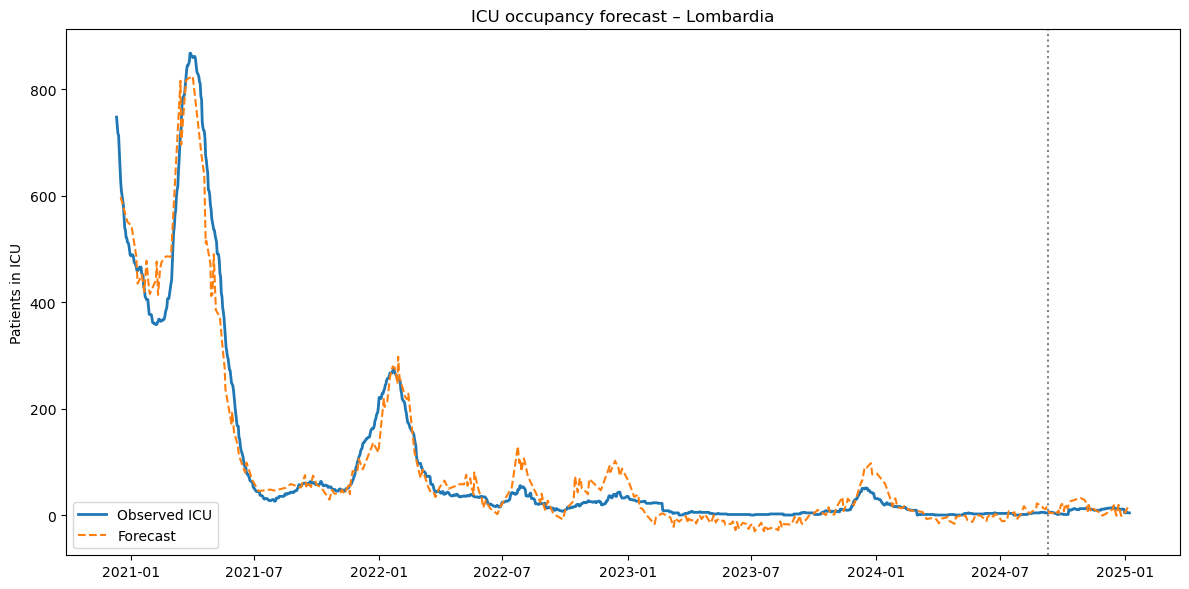

In [340]:
plt.figure(figsize=(12, 6))
plt.plot(df["ds"], df["y"], label="Observed ICU", linewidth=2)
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", linestyle="--")
plt.axvline(test["ds"].min(), color="gray", linestyle=":")
plt.title(f"ICU occupancy forecast – {REGIONE}")
plt.ylabel("Patients in ICU")
plt.legend()
plt.tight_layout()
plt.show()